In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [2]:
class controlledSDE(object):
    def __init__(self,rho,sigma,initial,delta_t,T):
        self.rho=rho
        self.sigma=sigma
        self.initial=initial
        self.delta_t=delta_t
        self.T=T
        self.reset()
    def reset(self):
        self.t=0
        self.state=self.initial
        self.done=False
    def step(self,action):
        dx=self.sigma*action*(self.rho*self.delta_t+np.random.normal(scale=math.sqrt(self.delta_t)))
        self.state+=dx
        self.t+=self.delta_t
        if self.t >=self.T:
            self.done=True
        return self.state,self.t,self.done       

In [3]:
class agent(object):
    def __init__(self,w,lam,theta_1,theta_2,phi_1,phi_2,lr_theta,lr_phi,T,z,alpha):
        self.w=w
        self.lam=lam
        self.theta_1=theta_1
        self.theta_2=theta_2
        self.phi_1=phi_1
        self.phi_2=phi_2
        self.lr_theta=lr_theta
        self.lr_phi=lr_phi
        self.T=T
        self.z=z
        self.alpha=alpha
        self.theta_0=-1*self.theta_2*self.T**2-self.theta_1*self.T-(self.w-self.z)**2
        self.theta_3=2*self.phi_2
        self.action_phi_1=self.phi_1
        self.action_phi_2=self.phi_2
    def value(self,t,x):
        return (x-self.w)**2*math.exp(-1*self.theta_3*(self.T-t))+self.theta_2*t**2+self.theta_1*t+self.theta_0
    def grad(self,t,x):
        return self.theta_3*(x-self.w)**2*math.exp(-1*self.theta_3*(self.T-t))+2*self.theta_2*t+self.theta_1
    def upgrade_value(self,delta_theta_1,delta_theta_2,delta_phi_1,delta_phi_2):
        self.theta_1-=lr_theta*delta_theta_1
        self.theta_2-=lr_theta*delta_theta_2
        self.phi_1-=lr_phi*delta_phi_1
        self.phi_2-=lr_phi*delta_phi_2
        #self.phi_2=np.clip(self.phi_2,a_min=0,a_max=None)
        self.theta_0=-1*self.theta_2*self.T**2-self.theta_1*self.T-(self.w-self.z)**2
        self.theta_3=2*self.phi_2
    def choose_action(self,t,x):
        center=-1*math.sqrt(2*abs(self.action_phi_2)/self.lam/math.pi)*math.exp((2*self.action_phi_1-1)/2)*(x-self.w)
        scale=math.sqrt(math.exp(2*self.action_phi_2*(self.T-t)+2*self.action_phi_1-1)/2/math.pi)
        return np.random.normal(center,scale)
    def improve_policy(self):
        self.action_phi_1=self.phi_1
        self.action_phi_2=self.phi_2
    def upgrade_w(self,delta_w):
        self.w-=self.alpha*delta_w

In [4]:
T=1
delta_t=1/252
mu=0.3
sigma=0.1
r=0.02
rho=(mu-r)/sigma
M=20000
N=10
lam=2
alpha=0.05
lr_theta=0.0005
lr_phi=0.0005
initial=1
z=1.4

In [5]:
env=controlledSDE(rho,sigma,initial,delta_t,T)

In [6]:
investor=agent(1,lam,1,1,1,1,lr_theta,lr_phi,T,z,alpha)

In [7]:
terminal_wealth=np.array([])
since=time.time()
for i in range(M):
    env.reset()
    theta_1_batch=np.array([])
    theta_2_batch=np.array([])
    phi_1_batch=np.array([])
    phi_2_batch=np.array([])
    done=False
    t=0
    x=initial
    while not done:
        action=investor.choose_action(t,x)
        next_x,next_t,done=env.step(action)
        TD=investor.grad(t,x)-investor.lam*(investor.phi_1+investor.phi_2*(T-t))
        theta_1_batch=np.append(theta_1_batch,TD*delta_t)
        theta_2_batch=np.append(theta_2_batch,TD*(next_t**2-t**2))
        phi_1_batch=np.append(phi_1_batch,-1*investor.lam*TD*delta_t)
        diff=-1*(2*(next_x-investor.w)**2*math.exp(-2*investor.phi_2*(T-next_t))*(T-next_t)-2*(x-investor.w)**2*math.exp(-2*investor.phi_2*(T-t))*(T-t))/delta_t-investor.lam*(T-t)
        phi_2_batch=np.append(phi_2_batch,TD*delta_t*diff)
        t=next_t
        #print(next_x)
        x=next_x
    #print(x)
    terminal_wealth=np.append(terminal_wealth,x)
    #print(terminal_wealth)
    delta_theta_1=np.sum(theta_1_batch)
    delta_theta_2=np.sum(theta_2_batch)
    delta_phi_1=np.sum(phi_1_batch)
    delta_phi_2=np.sum(phi_2_batch)
    investor.upgrade_value(delta_theta_1,delta_theta_2,delta_phi_1,delta_phi_2)
    investor.improve_policy()
    if (i+1)%N==0:
        delta_w=np.mean(terminal_wealth[-1*N:])-z
        investor.upgrade_w(delta_w)
        if (i+1)%(100*N)==0:
            print('episode:{},terminal error:{}'.format(i+1,delta_w))
            #print('phi_1:{},phi_2:{}'.format(investor.phi_1,investor.phi_2))
print('Training finished in {}s'.format(time.time()-since))

episode:1000,terminal error:-0.1914374578181599
episode:2000,terminal error:-0.17414347595629986
episode:3000,terminal error:-0.16095858023934606
episode:4000,terminal error:-0.21285513347982588
episode:5000,terminal error:-0.1553542086553097
episode:6000,terminal error:0.031504753388174045
episode:7000,terminal error:-0.020796831716833664
episode:8000,terminal error:-0.0025284529316271787
episode:9000,terminal error:0.1002696672763097
episode:10000,terminal error:0.014570049958797293
episode:11000,terminal error:0.0895915943108585
episode:12000,terminal error:0.03816821121354974
episode:13000,terminal error:0.040663770461952575
episode:14000,terminal error:-0.057841903534078476
episode:15000,terminal error:0.0222093586125498
episode:16000,terminal error:0.09023889459321754
episode:17000,terminal error:0.013293134835824283
episode:18000,terminal error:0.02919241115941551
episode:19000,terminal error:-0.02093147449484123
episode:20000,terminal error:0.07956422135721763
Training finished

In [8]:
MA_wealth=np.array([])
for i in range(0,M-50,50):
    MA_wealth=np.append(MA_wealth,np.mean(terminal_wealth[i:i+50]))

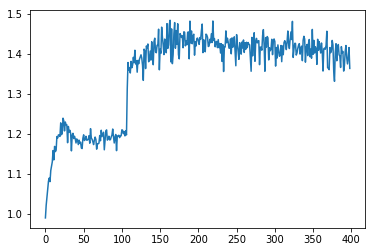

In [9]:
plt.plot(MA_wealth)

In [10]:
perform=np.array([])
for i in range(1000):
    env.reset()
    x=initial
    t=0
    done= False
    while not done:
        action=investor.choose_action(t,x)
        x,t,done=env.step(action)
    perform=np.append(perform,x)
avg_return=np.mean(perform)
variance=np.std(perform)**2
sharp=(np.mean(perform)-1)/np.std(perform)
print('Annualized Return:{}, Variance:{}, Sharp Ratio:{}'.format(avg_return,variance,sharp))

Annualized Return:1.3964115704548892, Variance:0.028088226741225634, Sharp Ratio:2.3652887220406296
